In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

##################  Загрузка данных
Xtrain = pd.read_csv('D:\Coding\data\phone_user_review_file_60.csv', encoding= 'utf-8')
Xtest = pd.read_csv('D:\Coding\data\phone_user_review_file_40.csv', encoding= 'utf-8')

In [2]:
print("Xtrain.shape(): ", Xtrain.shape,
      "\nXtest.shape(): ", Xtest.shape)

Xtrain.shape():  (163837, 11) 
Xtest.shape():  (98284, 11)


In [3]:
print("Xtrain.head():\n", Xtrain[['lang', 'score', 'extract']].head())

Xtrain.head():
   lang  score                                            extract
0   en    8.0  I've had the phone for awhile and it's a prett...
1   en    6.0  to be clear it is not the sellers fault that t...
2   en    9.0  Well i love this phone. i have had ton of phon...
3   en    4.0  I have had my Instinct for several months now ...
4   en    6.0  i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
# Преобразуем время
# Разделение времени на год и месяц
Xtrain['date'] = Xtrain['date'].apply(pd.to_datetime)
Xtrain['year'] = Xtrain['date'].apply(lambda x: x.year)
Xtrain['month'] = Xtrain['date'].apply(lambda x: x.month)

In [8]:
#Валидация на 2016 годе
Xtr = Xtrain[(Xtrain['year']==2015) & (Xtrain.lang == 'en')].head(200)
Xval = Xtrain[(Xtrain['year']==2016) & (Xtrain.lang == 'en')].head(50)
#score - оценка телефона
ytr = Xtr['score']
yval = Xval['score']

In [9]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 13) 
Xval.shape():  (50, 13) 
ytr.mean():  7.925 
yval.mean():  8.22


In [10]:
data = pd.concat([Xtr,Xval],axis = 0,ignore_index = True)

#у нас есть nan, поэтому преобразуем их к строке
data['content_clear'] = data['extract'].apply(str)
data['content_clear'] = data['content_clear'].apply(review_to_wordlist)

In [11]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['price', 'expected', 'phone', 'beat', 'work']


############## Word2vec ##############

In [12]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Тренировка модели
# size - размер вектора
#min_count - игнорирует все слова с total frequency меньше заданного значения
#workers - количество ядер PC
#window - максимальная дистанция между текущем словом и прогнозируемом в предложении

#model_w2v = word2vec.Word2Vec(data['content_clear'], size=50, window=10, workers=cpu_count())


######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [13]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [14]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(250, 300)

In [15]:
def split(train,y,ratio):
    idx = ratio
    return train[:idx, :], train[idx:, :], y[:idx], y[idx:]
y = data['score']
Xtr, Xval, ytr, yval = split(data_mean, y,200)

In [16]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (200, 300) 
Xval.shape():  (50, 300) 
ytr.mean():  7.925 
yval.mean():  8.22


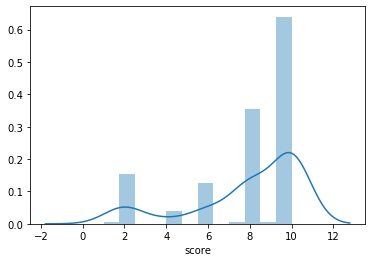

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############## Random Forest ##############

In [18]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest классификатор
clf_rf = RandomForestClassifier()



In [19]:
#классификатор 
clf_rf.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
y_pred=clf_rf.predict(Xtr)
y_pred

array([ 4.,  6., 10.,  2., 10.,  8., 10.,  8., 10.,  6.,  8.,  2.,  8.,
        8.,  2., 10., 10.,  8.,  8., 10.,  2.,  8.,  8., 10.,  1.,  2.,
       10., 10.,  8., 10.,  2.,  8., 10., 10., 10., 10., 10.,  8., 10.,
        2., 10., 10., 10.,  8.,  2., 10.,  6.,  9.,  7.,  2.,  2.,  8.,
       10.,  8., 10.,  2.,  8., 10.,  2., 10.,  4.,  8., 10., 10.,  6.,
        8., 10.,  2.,  8., 10.,  8., 10.,  2.,  6., 10., 10., 10., 10.,
       10.,  4., 10.,  8., 10., 10., 10.,  8.,  8.,  8., 10., 10.,  6.,
       10., 10., 10.,  8., 10., 10., 10.,  6., 10., 10., 10., 10.,  8.,
        8.,  8.,  6., 10.,  8.,  2., 10.,  8., 10., 10.,  6.,  8.,  4.,
        2.,  8., 10.,  8.,  2.,  8., 10.,  6.,  6.,  8., 10.,  2., 10.,
        2.,  6.,  8.,  8., 10., 10.,  8.,  8.,  8., 10., 10.,  8., 10.,
       10.,  8., 10., 10., 10., 10., 10.,  8.,  6.,  2.,  6., 10., 10.,
       10., 10., 10., 10.,  2., 10.,  8.,  6., 10.,  8., 10., 10., 10.,
       10., 10., 10.,  8., 10.,  6.,  8.,  8.,  6.,  4., 10.,  8

In [34]:
y_pred_v=clf_rf.predict(Xval)
y_pred_v

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10.,  4., 10., 10., 10.,  8., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [44]:
df = pd.DataFrame(list(zip(y_pred_v, yval)),
                                 columns = ['y_pred_v', 'yval'])
df.head(10)

,y_pred_v,yval
0,10.0,8.0
1,10.0,10.0
2,10.0,10.0
3,10.0,2.0
4,10.0,10.0
5,10.0,10.0
6,10.0,8.0
7,10.0,10.0
8,10.0,10.0
9,10.0,4.0


In [37]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(ytr, y_pred)
print(accuracy)

1.0


In [36]:
accuracy=accuracy_score(yval, y_pred_v)
print(accuracy)

0.48


In [31]:
from sklearn.metrics import classification_report

print(classification_report(ytr, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00        23
         4.0       1.00      1.00      1.00         6
         6.0       1.00      1.00      1.00        19
         7.0       1.00      1.00      1.00         1
         8.0       1.00      1.00      1.00        53
         9.0       1.00      1.00      1.00         1
        10.0       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [38]:
print(classification_report(yval, y_pred_v))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         2
         6.0       0.00      0.00      0.00         5
         8.0       0.00      0.00      0.00        11
         9.0       0.00      0.00      0.00         2
        10.0       0.50      0.92      0.65        26

    accuracy                           0.48        50
   macro avg       0.07      0.13      0.09        50
weighted avg       0.26      0.48      0.34        50

